### Install Dependencies


In [1]:
# GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ecefeb8c-e2e3-fc9d-2e57-852d5912163f)


In [2]:
# Install YOLOV5
!git clone https://github.com/ultralytics/yolov5.git

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [3]:
# yolov5
%cd yolov5

/content/yolov5


In [4]:
# Install requirements
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Custom Dataset

In [5]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [6]:
# Download and uzip data
!curl -L mask_detection.zip; unzip mask_detection.zip; rm mask_detection.zip

curl: (6) Could not resolve host: mask_detection.zip
unzip:  cannot find or open mask_detection.zip, mask_detection.zip.zip or mask_detection.zip.ZIP.
rm: cannot remove 'mask_detection.zip': No such file or directory


### Define Model Configuration and Architecture

In [7]:
# define number of classes based on YAML
import yaml
with open("/content/drive/MyDrive/data/mask_detection/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
# Classes
num_classes

'2'

### Model Training

In [9]:
#this is the model configuration we will use
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [10]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))



In [11]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [12]:
%cp /content/drive/MyDrive/data/mask_detection/data.yaml /content/yolov5/data/custom_data.yaml

In [13]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5
!python train.py --img 416 --batch 16 --epochs 300 --data '/content/drive/MyDrive/data/mask_detection/data.yaml' --cfg /content/yolov5/models/yolov5s.yaml

/content/yolov5
train: weights=yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=/content/drive/MyDrive/data/mask_detection/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-181-g3812a1a Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, ob

### Evaluation & Inference

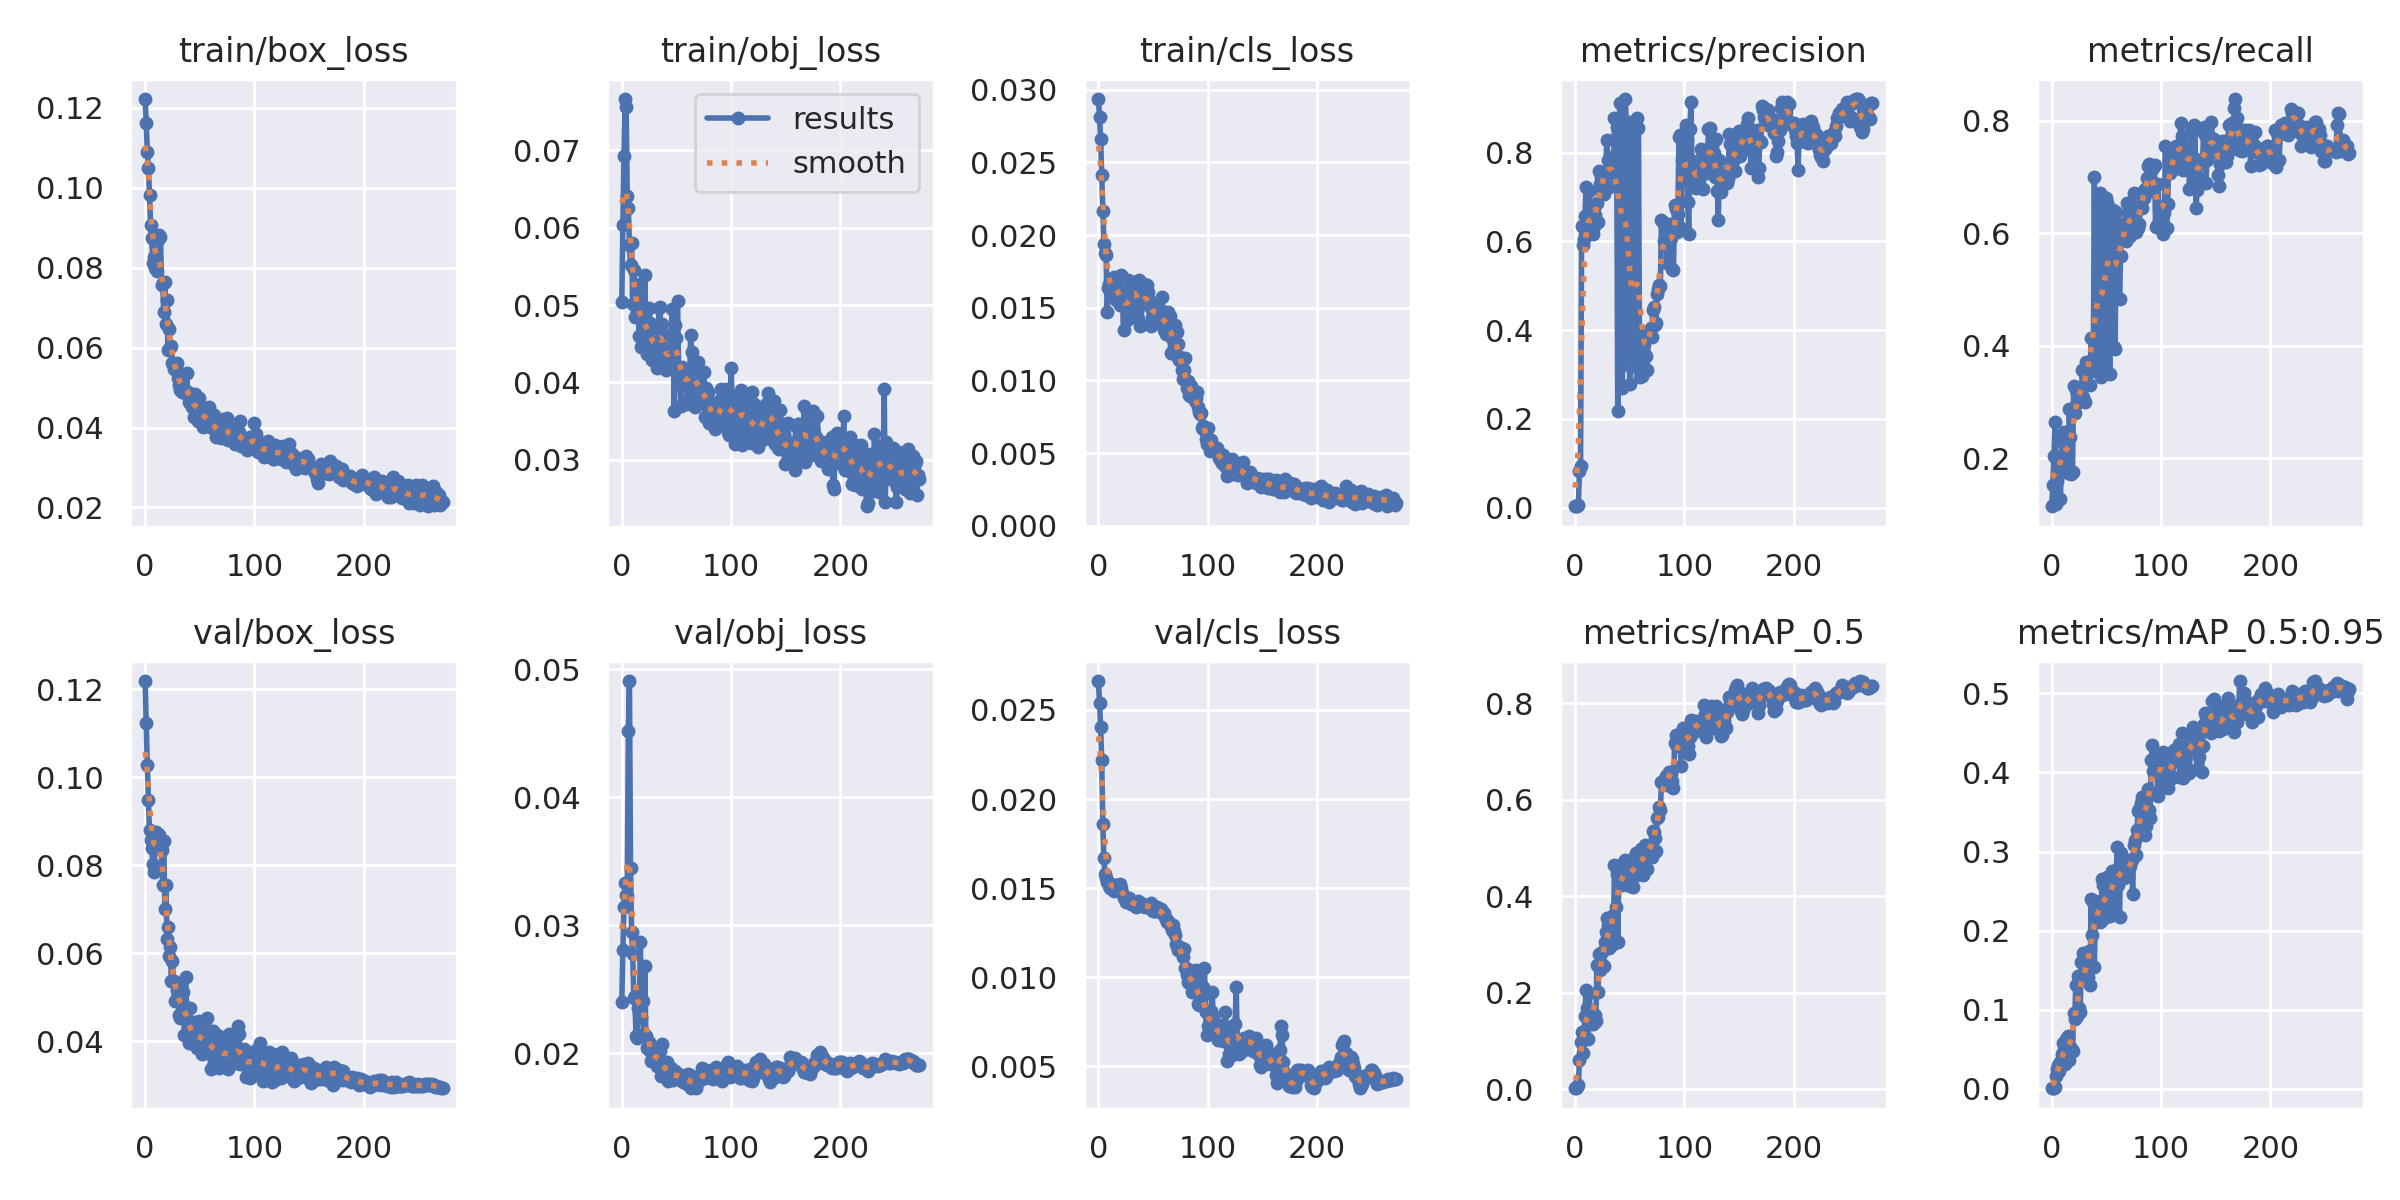

In [17]:
# Run
# we can also output some older school graphs if the tensor board isn't working for whatever reason..
from IPython.display import Image, clear_output
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/exp4/results.png', width=1000)  # view results.png



In [29]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/exp4/weights/best.pt --img 416 --conf 0.5 --source /content/team-mask.jpeg

/content/yolov5
detect: weights=['/content/yolov5/runs/train/exp4/weights/best.pt'], source=/content/team-mask.jpeg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-181-g3812a1a Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/team-mask.jpeg: 288x416 4 masks, 41.8ms
Speed: 0.3ms pre-process, 41.8ms inference, 1.4ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp8


GROUND TRUTH AUGMENTED TRAINING DATA:


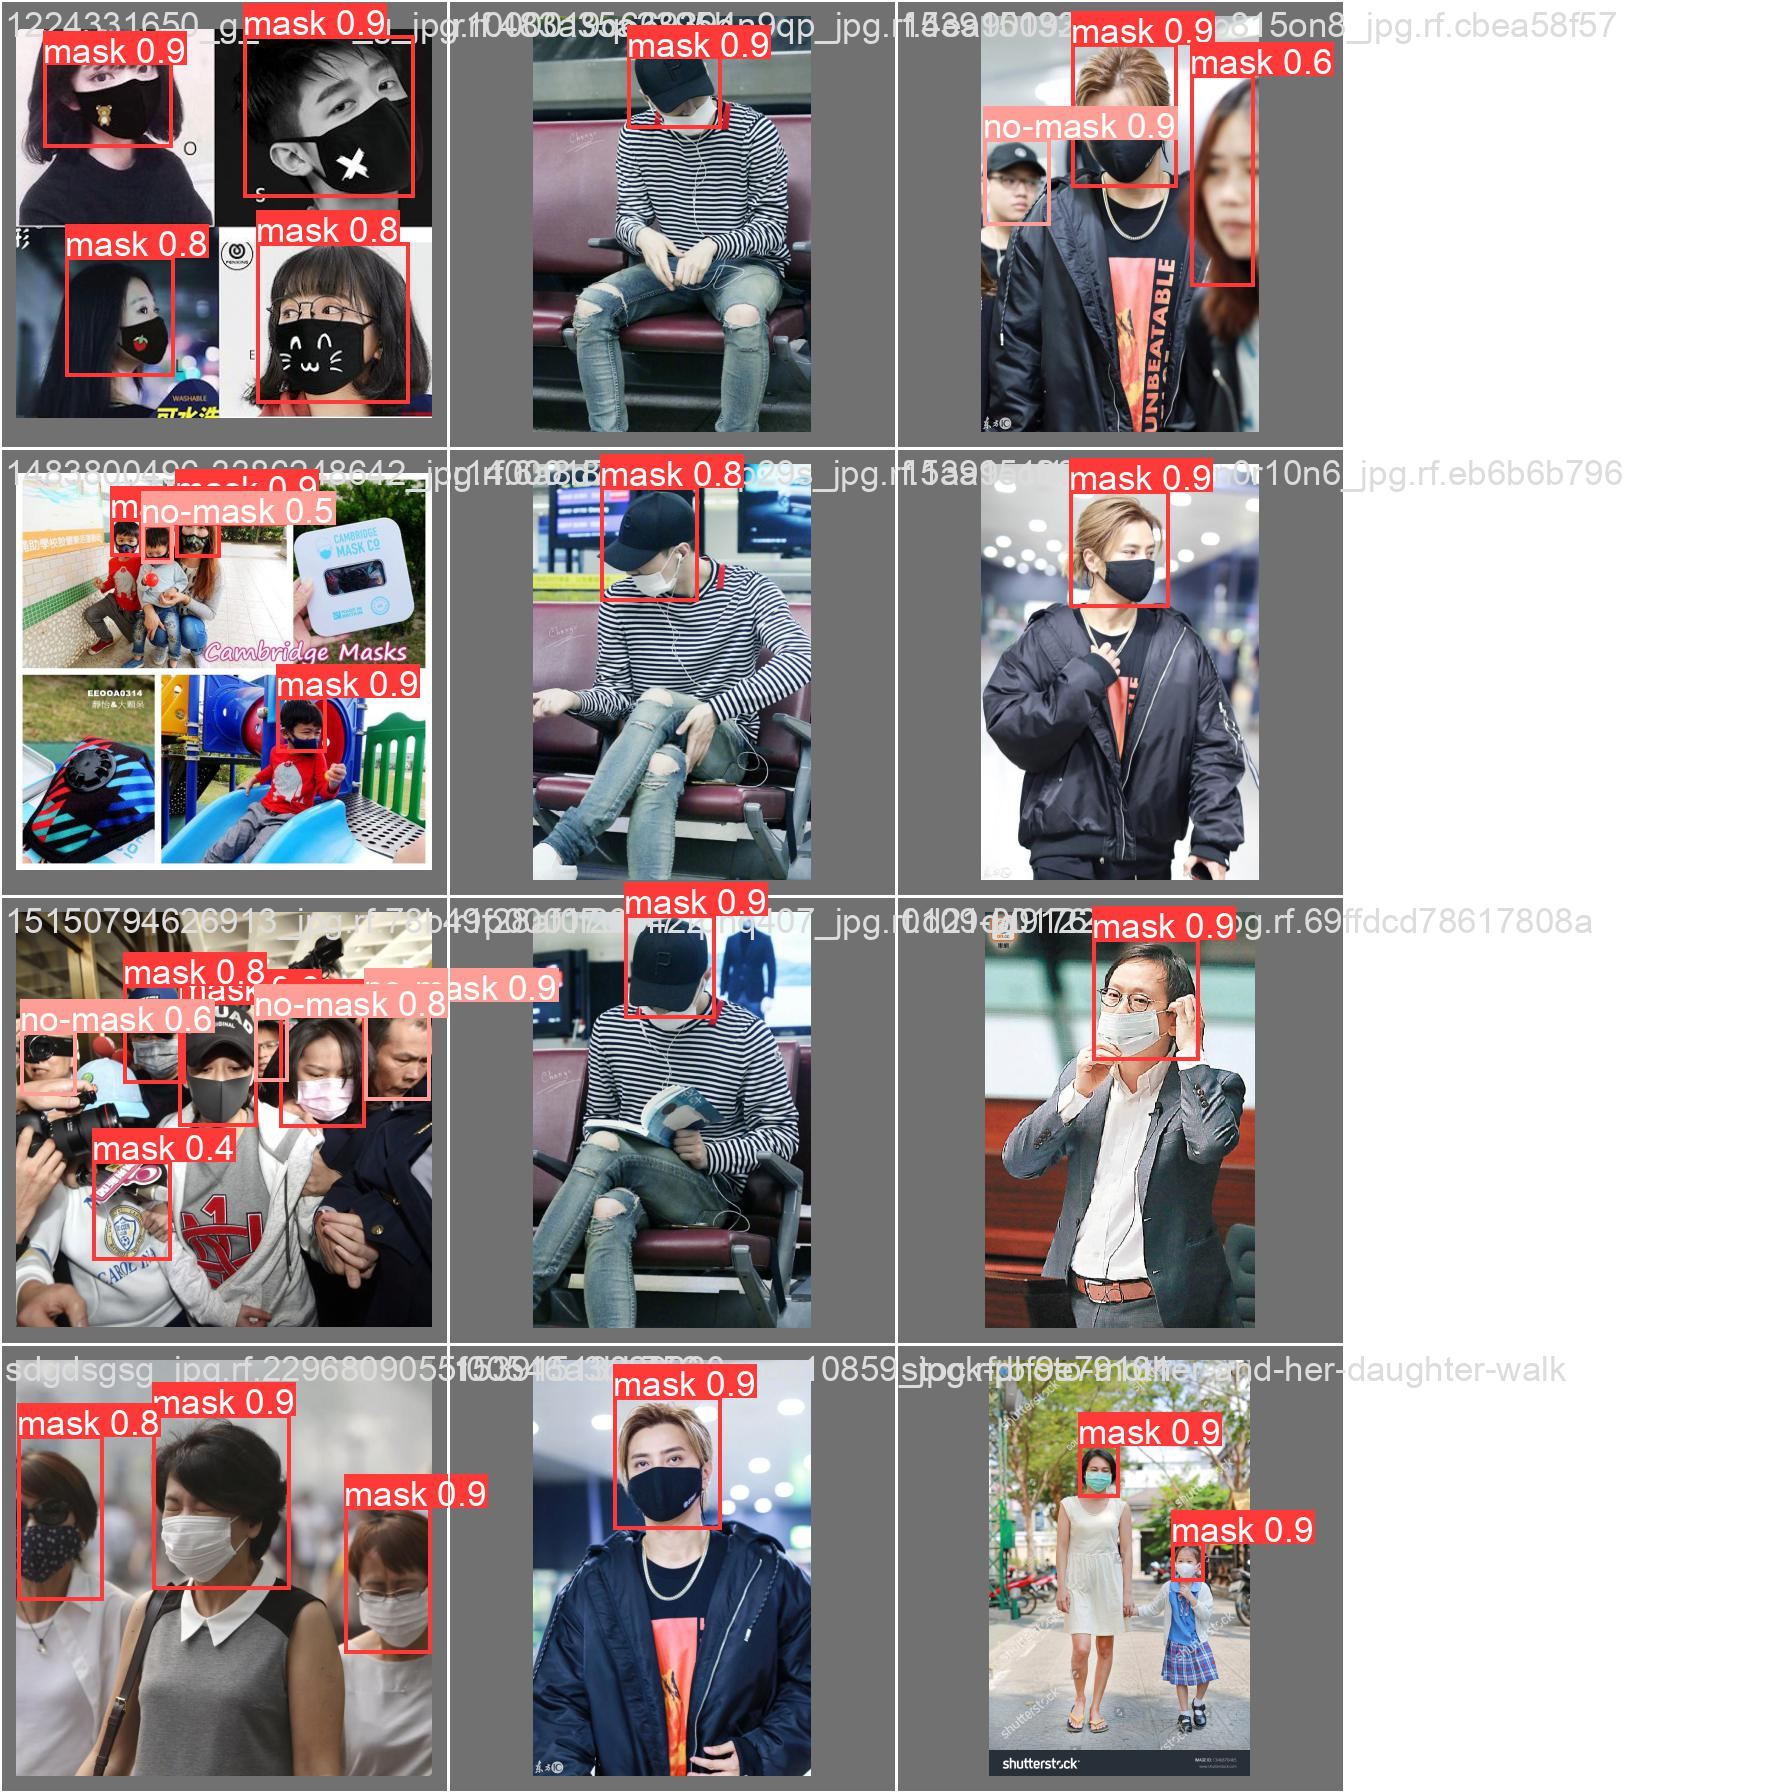

In [24]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/exp4/val_batch1_pred.jpg', width=900)


GROUND TRUTH AUGMENTED TRAINING DATA:


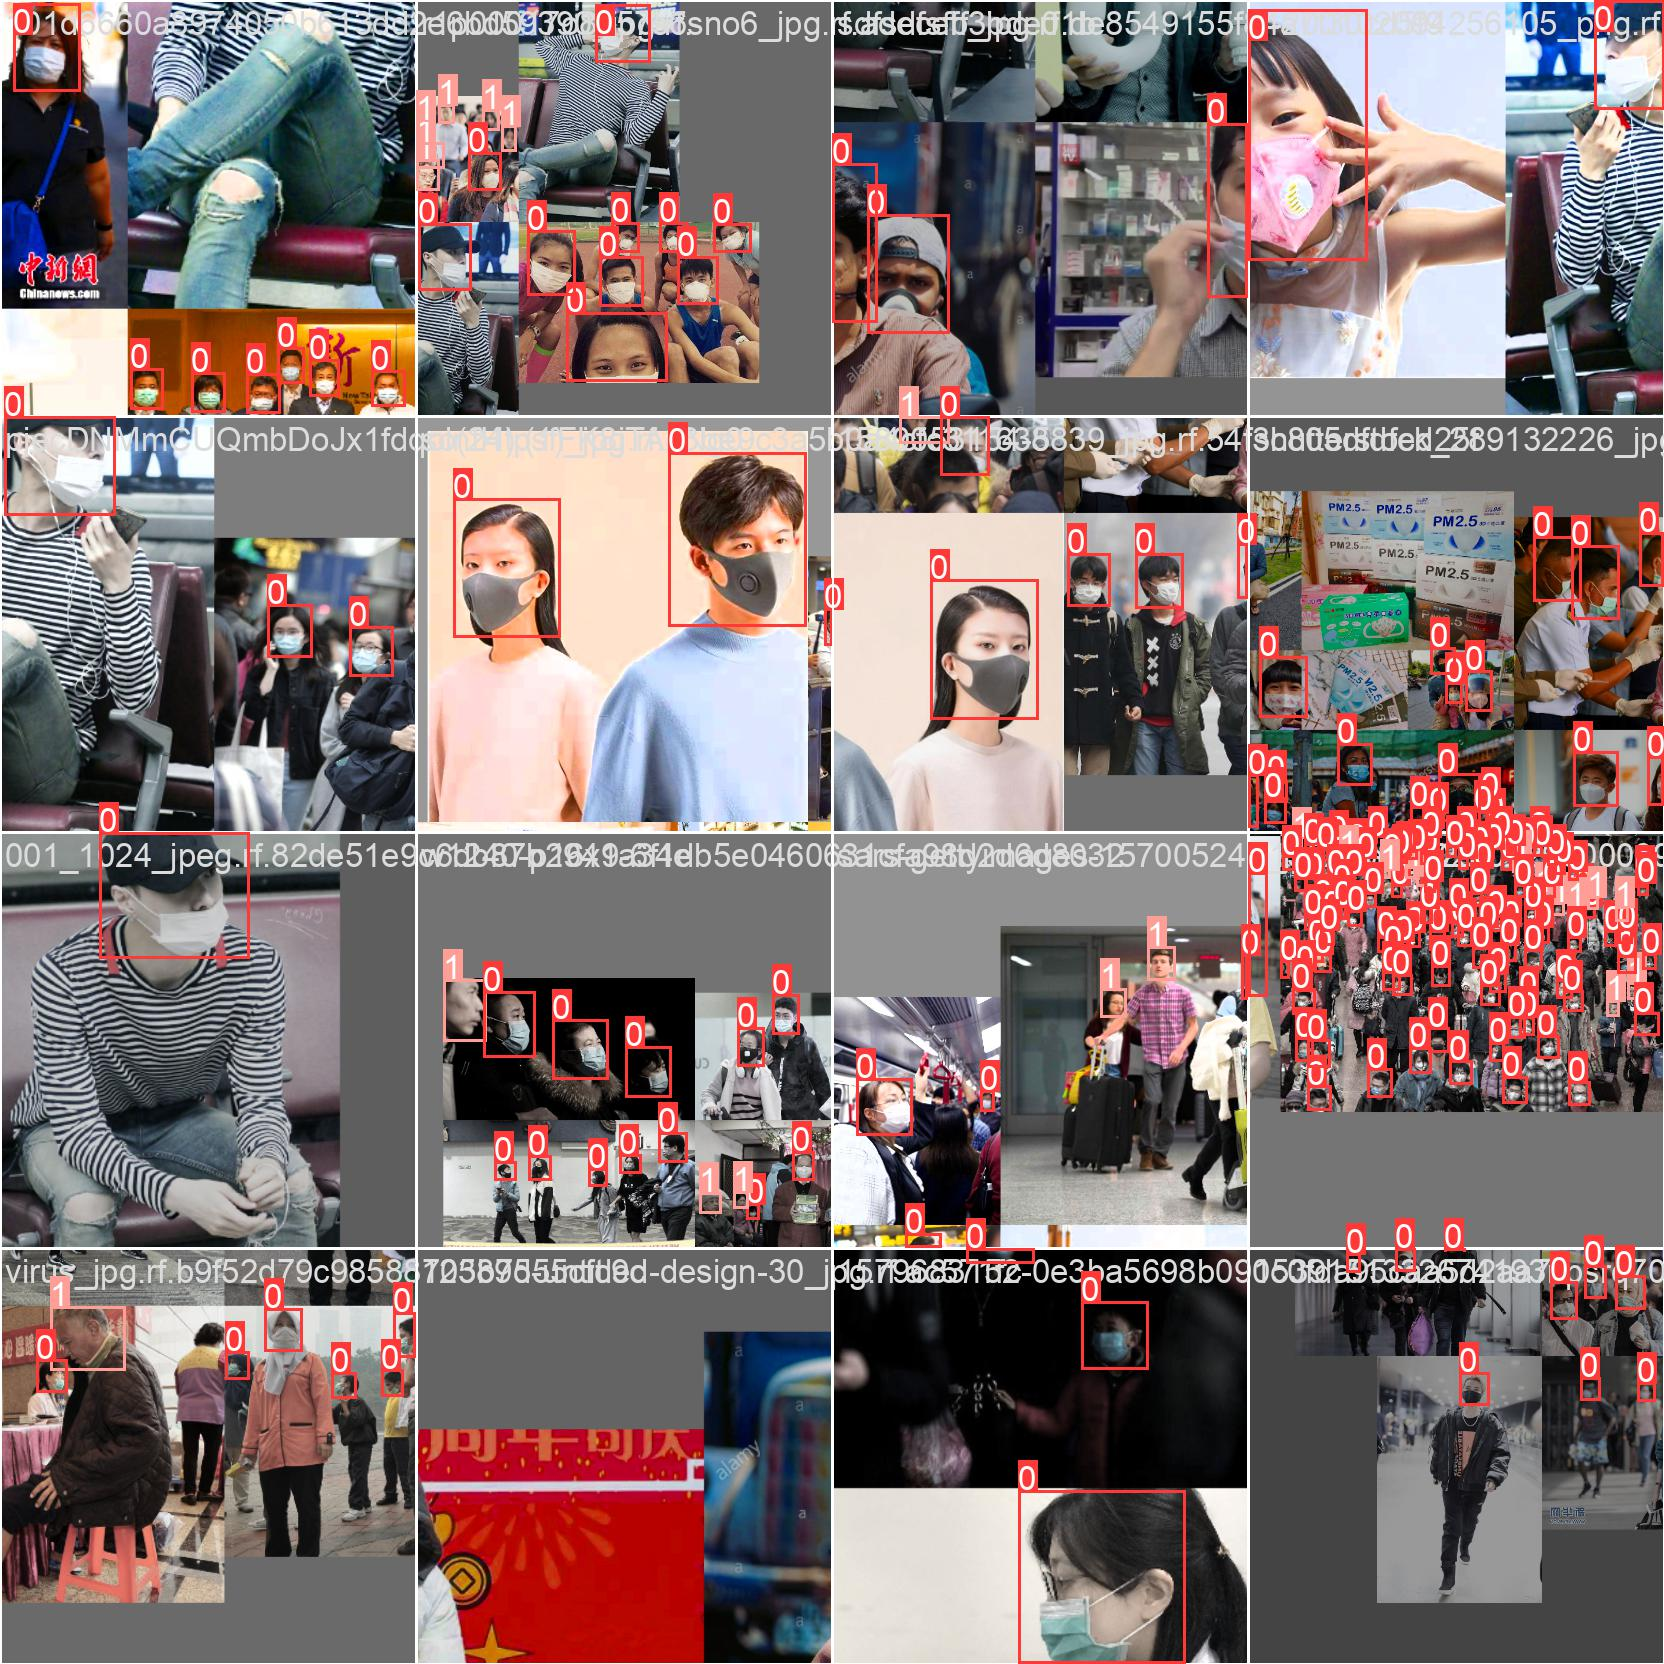

In [25]:
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/exp4/train_batch2.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


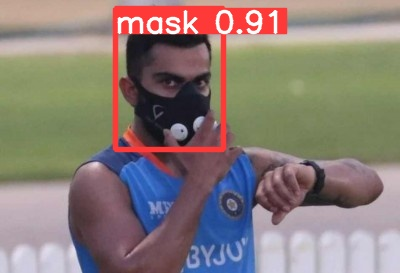

In [28]:
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/detect/exp5/kohli-1662187527.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


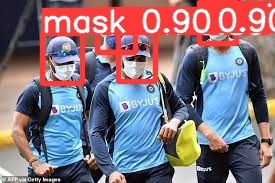

In [30]:
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/detect/exp8/team-mask.jpeg', width=900)

In [23]:
# optional, zip to download weights and results locally
# To deploy, you'll need to export your weights and save them to use later.
!zip -r export.zip runs/detect
!zip -r export.zip runs/train/exp4/weights/best.pt
!zip export.zip runs/train/exp4/*

  adding: runs/detect/ (stored 0%)
  adding: runs/detect/exp3/ (stored 0%)
  adding: runs/detect/exp3/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg (deflated 4%)
  adding: runs/detect/exp/ (stored 0%)
  adding: runs/detect/exp4/ (stored 0%)
  adding: runs/detect/exp2/ (stored 0%)
  adding: runs/detect/exp5/ (stored 0%)
  adding: runs/detect/exp5/kohli-1662187527.jpg (deflated 2%)
  adding: runs/detect/exp6/ (stored 0%)
  adding: runs/detect/exp6/no_mask.jpeg (deflated 4%)
  adding: runs/train/exp4/weights/best.pt (deflated 8%)
  adding: runs/train/exp4/confusion_matrix.png (deflated 32%)
  adding: runs/train/exp4/events.out.tfevents.1686884557.f1483c60ca69.10011.0 (deflated 37%)
  adding: runs/train/exp4/F1_curve.png (deflated 11%)
  adding: runs/train/exp4/hyp.yaml (deflated 45%)
  adding: runs/train/exp4/labels_correlogram.jpg (deflated 42%)
  adding: runs/train/exp4/labels.jpg (deflated 33%)
  adding: runs/train/exp4/opt.yaml (deflated 49%)
